# Support Vector Machines (SVM)
## Utility functions

In [1]:
import os
from os import path

import numpy as np
import cv2
from skimage import io, color, transform
import matplotlib.pyplot as plt

In [2]:
def resize_image(img, size, padding=255):
    '''
    Resize the given image to specified size
    Inputs:
        img = Image to be resized (Numpy NDArray)
        size = Scalar value. Image will be resized to (size, size)
    Returns:
        reszd_img = Resized image (Numpy NDArray)
    '''
    # Append zeros or ones based on the choice of padding
    # to maintain the aspect ratio of the image
    rows, cols = img.shape[:2]
    max_size = max(rows, cols)
    canvas = np.ones((max_size, max_size), np.uint8) * padding
    
    # Place the actual image at the center of the canvas
    c_x, c_y = max_size / 2, max_size / 2
    x_beg = max(0, c_x - (cols / 2))
    y_beg = max(0, c_y - (rows / 2))
    x_end, y_end = x_beg + cols, y_beg + rows
    canvas[y_beg: y_end, x_beg: x_end] = img
        
    # Resize the image and write to op_dir_path specified
    reszd_img = transform.resize(canvas, (size, size))
    reszd_img = np.asarray(reszd_img * 255, np.uint8)
    return reszd_img

In [3]:
def extract_features(image):
    '''
    Extract the features from the Image
    '''
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_img = resize_image(gray_img, 250)
    gray_img = cv2.GaussianBlur(gray_img, (5, 5), 0)
    
    # Binarize the image using Adaptive thresholding
    th, bin_img = cv2.threshold(gray_img, 250, 255, cv2.THRESH_BINARY_INV)
    
    # Close the holes by Morphological operations (Erosion and Dilation)
    struct_elem = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    smooth_bin_img = cv2.erode(bin_img, struct_elem, iterations=1)
    smooth_bin_img = cv2.dilate(smooth_bin_img, struct_elem, iterations=2)
    
    # Find all the contours from the binary image
    img, contours, heirarchy = cv2.findContours(smooth_bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Find the circularity
    x, y, w, h = cv2.boundingRect(contours[0])
    rect_area = w * h
    contour_area = cv2.contourArea(contours[0])
    circularity = contour_area / rect_area
    
    # Find the compactness
    mask_img = np.zeros_like(smooth_bin_img)
    mask_img = cv2.drawContours(mask_img, [contours[0]], -1, 255, -1)
    white_mask_img = cv2.bitwise_and(smooth_bin_img, smooth_bin_img, mask=mask_img)
    white_area = cv2.countNonZero(white_mask_img)
    compactness = white_area / contour_area
    
    features = [circularity, compactness]
    
    return features

In [4]:
def load_data_from_imgs(data_dir, class_label):
    '''
    Read images from the data directory
    Extract features from images and load that into array
    '''
    all_features = []
    for img_name in os.listdir(data_dir):
        img_path = path.join(data_dir, img_name)
        image = cv2.imread(img_path)
        img_features = extract_features(image)
        img_features.append(class_label)
        all_features.append(img_features)
    all_features = np.array(all_features, np.float)
    return all_features

In [5]:
def test_svm(model, X, y):
    '''
    Test the trained model with the test data
    '''
    pred_acc_list = []
    for sample, label in zip(X, y):
        pred = model.predict(sample.reshape(1, -1))[0]
        pred_acc_list.append(int(pred) == int(label))
    accuracy = sum(pred_acc_list) / float(len(pred_acc_list)) * 100
    return accuracy

## Loading Data

In [22]:
data_dir = '../data/nuts_n_bolts_master/all_svm/'
train_dir = path.join(data_dir, 'train')
test_dir = path.join(data_dir, 'test')

# Collect the Training and Test data
nuts_class, bolts_class = 0, 1
train_nuts_data = load_data_from_imgs(path.join(train_dir, 'nuts'), nuts_class)
train_bolts_data = load_data_from_imgs(path.join(train_dir, 'bolts'), bolts_class)
train_data = np.append(train_nuts_data, train_bolts_data, axis=0)
np.random.shuffle(train_data)

# Test data
test_nuts_data = load_data_from_imgs(path.join(test_dir, 'nuts'), nuts_class)
test_bolts_data = load_data_from_imgs(path.join(test_dir, 'bolts'), bolts_class)
test_data = np.append(test_nuts_data, test_bolts_data, axis=0)
np.random.shuffle(test_data)

## Decision Tree

In [23]:
from sklearn import tree
X, y = train_data[:, :2], train_data[:, 2]
test_X, test_y = test_data[:, :2], test_data[:, 2]
dec_tr_clf = tree.DecisionTreeClassifier()
dec_tr_clf = dec_tr_clf.fit(X, y)

In [24]:
print('Accuracy', test_svm(dec_tr_clf, test_X, test_y))

('Accuracy', 87.2340425531915)


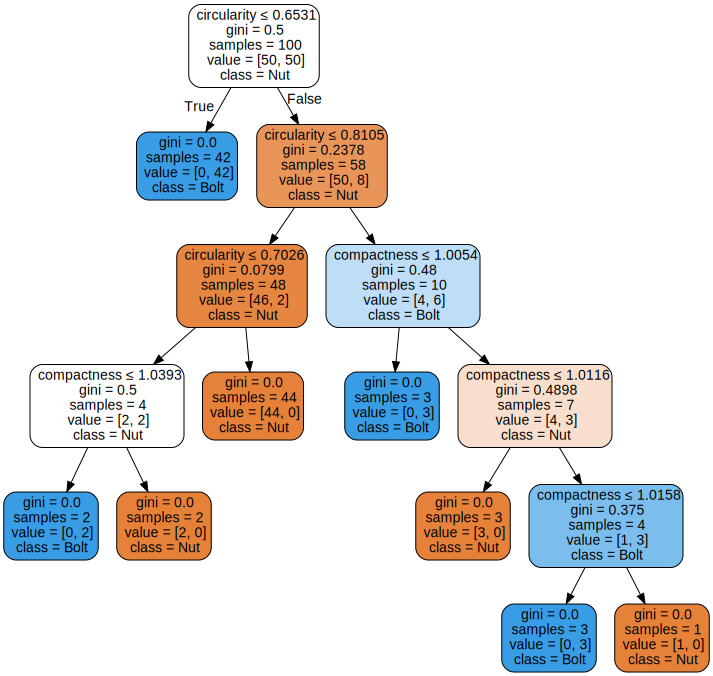

In [27]:
import graphviz 
dot_data = tree.export_graphviz(dec_tr_clf, out_file=None,
                                feature_names=['circularity', 'compactness'],
                                class_names=['Nut', 'Bolt'],
                                filled=True, rounded=True,
                                special_characters=True) 
graph = graphviz.Source(dot_data) 
graph.render("Nuts and Bolts")
graph

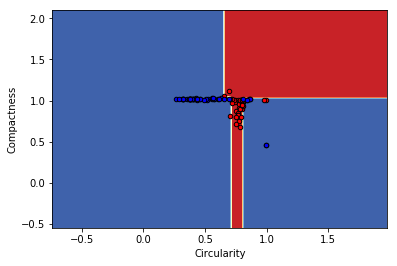

In [35]:
plot_step = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))
#plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

Z = dec_tr_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

plt.xlabel('Circularity')
plt.ylabel('Compactness')
target_names = ['Nut', 'Bolt']

# Plot the training points
for i, color in zip(range(2), 'rb'):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1], c=color, label=target_names[i],
                cmap=plt.cm.RdYlBu, edgecolor='black', s=20)
plt.show()

## SVM with 2 Features
**Features**
* Circularity
* Compactness  

**Class lables**
* Nuts = 0
* Bolts = 1

In [72]:
# Training with SVM
from sklearn import svm
#clf = svm.SVC(verbose=True, max_iter=20)
clf = svm.LinearSVC(C=1.0, max_iter=10, verbose=True)

In [73]:
X, y = train_data[:, :2], train_data[:, 2]
clf.fit(X, y)

[LibLinear]

/home/dhivakar/sys/sw/virt_envs/ahws/local/lib/python2.7/site-packages/sklearn/svm/base.py:920: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=10,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=True)

In [74]:
# Get the test data and predict
test_X, test_y = test_data[:, :2], test_data[:, 2]
test_svm(clf, test_X, test_y)

The Acccuracy of the model is =  85.4166666667


85.41666666666666

### SVM Visualization

In [46]:
def make_meshgrid(x, y, h=.02):
    '''
    Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    '''
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    '''
    Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    '''
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

Accuracy of SVC with linear kernel is = 85.4166666667
Accuracy of LinearSVC (linear kernel) is = 89.5833333333
Accuracy of SVC with RBF kernel is = 85.4166666667
Accuracy of SVC with polynomial (degree 3) kernel is = 85.4166666667


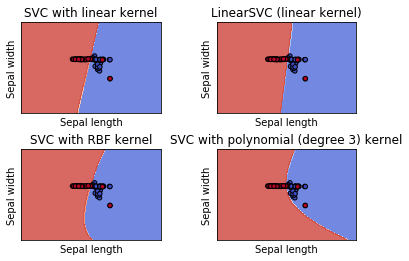

In [91]:
C = 1.0  # SVM regularization parameter
iterations = 50

# We create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
models = (svm.SVC(kernel='linear', C=C, max_iter=iterations),
          svm.LinearSVC(C=C, max_iter=iterations),
          svm.SVC(kernel='rbf', gamma=0.7, C=C, max_iter=iterations),
          svm.SVC(kernel='poly', degree=3, C=C, max_iter=iterations))
models = (clf.fit(X, y) for clf in models)

# title for the plots
titles = ('SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel')

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X[:100, 0], X[:100, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    print('Accuracy of {} is = {}'.format(title, test_svm(clf, test_X, test_y)))
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y[:100], cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Circularity')
    ax.set_ylabel('Compactness')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
plt.show()

## Training SVM with Multiple Features

In [93]:
def read_data(csv_file_path):
    '''
    Read the training data and return X and y
    Returns:
        X = Training samples (m - samples of n features)
        y = Lables corresponding to each sample (size - m)
    '''
    data = np.loadtxt(csv_file_path, delimiter=',')
    rows, cols = data.shape
    y = data[:, -1].astype(np.int)
    X = data[:, :cols-1]
    return X, y

In [101]:
import pickle

In [129]:
def train_svm(train_data_file):
    '''
    Train an SVM model for the given X and y
    '''
    C = 1.0
    #clf = svm.SVC(kernel='rbf', gamma=0.7, C=C, max_iter=100)
    clf = svm.LinearSVC(C=C, max_iter=100)
    #clf = svm.SVC(kernel='linear', C=C, max_iter=100)
    
    # Get the training data
    X, y = read_data(train_data_file)
    clf.fit(X, y)
    return clf

In [98]:
def nut_or_bolt(model, img_file_path):
    '''
    Given an image file, predicts and returns the kind
    Returns:
        Nut or Bolt (a string)
    '''
    img = io.imread(img_file_path)
    img = color.rgb2gray(img)
    img = np.asarray(img * 255, np.uint8)
    reszd_img = resize_image(img, 50).astype(np.float) / 255.0
    
    ip_data = reszd_img.flatten()
    pred = model.predict(ip_data.reshape(1, -1))
    print pred
    result = 'Nut' if not pred[0] else 'Bolt'
    return result

In [130]:
train_data_file = '../data/nuts_n_bolts_master/all/50x50/nuts_and_bolts_train.csv'
test_data_file = '../data/nuts_n_bolts_master/all/50x50/nuts_and_bolts_test.csv'
model_file_path = '../models/nut_n_bolt.pkl'

# Train the model and store it in a file. It can be loaded anytime later
model = train_svm(train_data_file)
pickle.dump(model, open(model_file_path, 'w'))

# Take an image and show the prediction + image
loaded_model = pickle.load(open(model_file_path, 'r'))

# Calculate the accuracy of the model
X, y = read_data(test_data_file)
accuracy = test_svm(loaded_model, X, y)

The Acccuracy of the model is =  84.6153846154
